In [44]:
%load_ext line_profiler
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac
import h5py
import scipy
from collections import namedtuple

edge_chan = 1024

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [45]:
mir_data = MirParser("/Users/gkeating/data/SMA/ozone/211009_04:56:19", has_auto=True)
freq_range = [min(mir_data.sp_data['fsky']) - 2.0, max(mir_data.sp_data['fsky']) + 2.0]
ozone_model = Ozone('/Users/gkeating/newdata/')#, freq_range=freq_range)
pwv = 2
_ = ozone_model(zenith=0.1, pwv=pwv, return_pwv_jacobian=True)

In [89]:
with h5py.File('../src/data/10923_specsoln.mat') as compass_solns:
    bp_arr = np.square(compass_solns['bandpassArr']).sum(axis=-1)
    freq_arr = np.divide(compass_solns['freqArr'], 1e9)
    scale_fac = np.swapaxes(np.asarray(compass_solns['gainApEff']).reshape(8, 2, -1), axis1=0, axis2=1)
    sb_arr = compass_solns['sbArr'][0]
    win_arr = compass_solns['winArr'][0]
    rx_arr = compass_solns['rxList'][0]


nWin = int(max(win_arr))
nSB = int(max(sb_arr) + 1)
nChan = 16384
SolnKey = namedtuple('SolnKey', ['Antenna', 'Receiver'])

# print("Idx | SB  | Chunk")
# print("-----------------")
cal_map = {}
scale_fac_map = {}
for idx in range(len(rx_arr)):
    for jdx in range(8):
        key = SolnKey(jdx + 1, rx_arr[idx])
        cal_arr = np.zeros((nWin, nSB, nChan - int(2 * edge_chan)))
        sf_arr = np.zeros((nWin, nSB))
        for kdx in range(len(sb_arr)):
            win_idx = int(win_arr[kdx]) - 1
            sb_idx = int(sb_arr[kdx])
            cal_arr[win_idx, sb_idx] = bp_arr[idx, jdx, kdx, edge_chan:-edge_chan] / scale_fac[idx, jdx, kdx]
            sf_arr[win_idx, sb_idx] = scale_fac[idx, jdx, kdx]
        cal_map[key] = cal_arr
        scale_fac_map[key] = sf_arr


In [48]:
freqs, stacked, meta = stack_antenna_ac(
    mir_data,
    antenna_num=1,
    rx_num=0,
    normalization=False,
    return_meta=True,
    spw_baselining=False,
    mad_dev=15.0,
    window_size=11,
)

soln_key = SolnKey(Antenna=1, Receiver=0)

In [96]:
pwv=2.0
mir_data.select(reset=True)
elevation = mir_data.eng_data.get_value("actual_el", where=("antenna", "eq", 1))

model_arr = np.zeros_like(stacked)
delta_arr = np.zeros_like(stacked)

za_arr = np.radians(90 - elevation)
model_freqs = ozone_model.data['freq']['map']
nspws = stacked.shape[1]
gain_fac = np.array([1.1, 0.9])[:, None]
for idx, zenith in enumerate(za_arr):
    model_temps, delta_temps = ozone_model(pwv=pwv, zenith=zenith, return_pwv_jacobian=True, freq_arr=freqs)
    # cal_soln = cal_map[soln_key]
    cal_soln = scale_fac_map[soln_key][..., None]
    # cal_soln = 1
    model_arr[idx] = (model_temps * cal_soln).sum(axis=1)
    delta_arr[idx] = (delta_temps * cal_soln).sum(axis=1)

(294, 6, 14336)


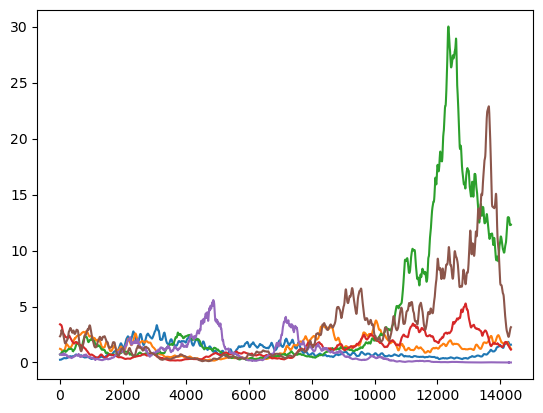

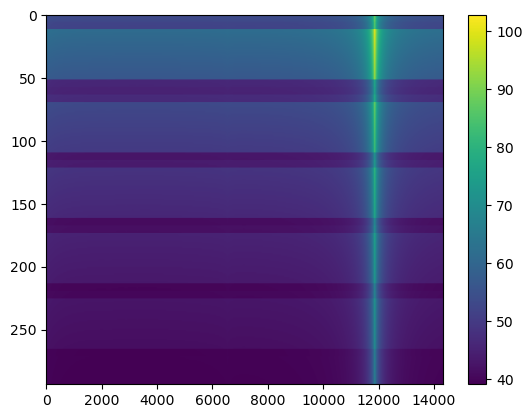

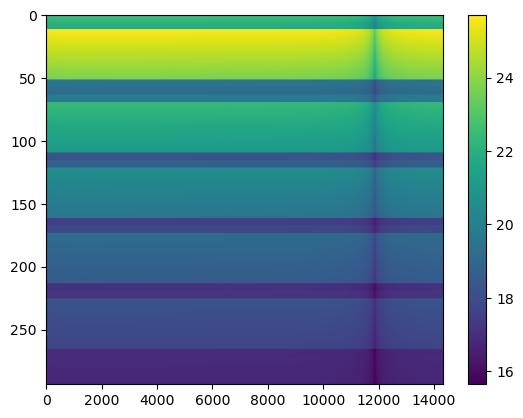

In [97]:
print(model_arr.shape)
plt.plot(cal_map[soln_key][:, 0, :].T)
plt.figure()
plt.imshow(model_arr[:, 0, :], aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(delta_arr[:, 0, :], aspect='auto')
plt.colorbar()


/var/folders/6k/9m18n_s947n5ts95gb8v5v180000gn/T/ipykernel_42759/847461287.py:6: RuntimeWarning: All-NaN slice encountered
  item /= np.nanmedian(item,axis=0)[None]


np.float32(1.034078)

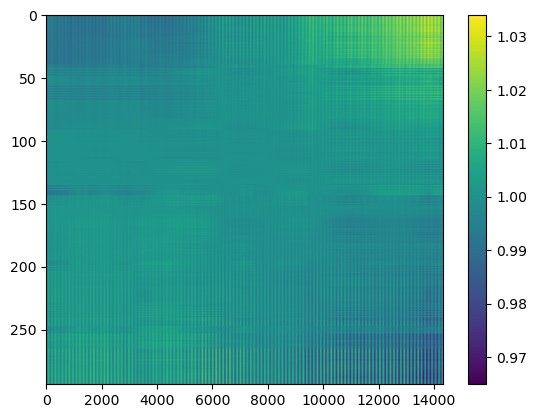

In [103]:
old_stack = stacked * 1
tsys = 100
new_stack = stacked / (model_arr+tsys)

for item in [old_stack, new_stack]:
    item /= np.nanmedian(item,axis=0)[None]
    item /= np.nanmedian(item,axis=2)[:, :, None]

plt.imshow(new_stack[np.argsort(elevation), 3, :], aspect='auto')
plt.colorbar()
np.nanmax(new_stack[:, 3, :].flatten())